In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise

[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and
some might not love him) from the TV series "The Big Bang Theory" has gotten
into an argument with Leonard from the same TV show. Sheldon insists that he
knows the show better than anyone, and keeps making various claims about the
show, which neither of them know how to prove or disprove. The two of them have
reached out to you ladies and gentlemen, as data scientists, to help them. You
will be given the full script of the series, with information on the episode,
the scene, the person saying each dialogue line, and the dialogue lines
themselves.

Leonard has challenged several of Sheldon's claims about the show, and
throughout this exam you will see some of those and you will get to prove or
disprove them, but remember: sometimes, we can neither prove a claim, nor
disprove it!


## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent
ones.**

Our friends' argument concerns the entire show. We have given you a file in the
`data/` folder that contains the script of every single episode. New episodes
are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue
lines. Some lines are said by multiple people (for example, lines indicated by
'All' or 'Together'); **you must discard these lines**, for the sake of
simplicity. However, you do not need to do it for Q1 in this task -- you'll take
care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and
episode, creating a dataframe where each row has the episode and scene where a
dialogue line was said, the character who said it, and the line itself. You do
not need to extract the proper name of the episode (e.g. episode 1 can appear as
"Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot
Episode"). Then, answer the following question: In total, how many scenes are
there in each season? We're not asking about unique scenes; the same location
appearing in two episodes counts as two scenes. You can use a Pandas dataframe
with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**


In [4]:
!head -10 data/all_scripts.txt

>> Series 01 Episode 01 – Pilot Episode
> A corridor at a sperm bank.
Sheldon: So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.
Leonard: Agreed, what’s your point?
Sheldon: There’s no point, I just think it’s a good idea for a tee-shirt.
Leonard: Excuse me?
Receptionist: Hang on.
Leonard: One across is Aegean, eight down is Nabakov, twenty-six across is MCM, fourteen down is… move your finger… phylum, which makes fourteen across Port-au-Prince. See, Papa Doc’s capital idea, that’s Port-au-Prince. Haiti.
Receptionist: Can I help you?
Leonard: Yes. Um, is this the High IQ sperm bank?


In [5]:
lines_of_dialogue = []
with open("data/all_scripts.txt", "r") as file:
    episode, scence = "", ""
    for line in file:
        line = line.strip()
        if line.startswith("All") or line.startswith("Together"):
            continue
        # New episodes
        elif line[:2] == ">>":
            episode = line[3:]
        # New scence
        elif line[:1] == ">":
            scence = line[2:]
        # Line of dialogue
        else:
            character, dialogue = map(lambda x: x.strip(), line.split(":", 1))
            lines_of_dialogue.append((episode, scence, character, dialogue))

    df = pd.DataFrame(
        lines_of_dialogue, columns=["Episode",
                                    "Scence", "Character", "Dialogue"]
    )

df.head(5)

,Episode,Scence,Character,Dialogue
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."
3,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?
4,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.


**Q2**. Now, let's define two sets of characters: all the characters, and
recurrent characters. Recurrent characters are those who appear in more than one
episode. For the subsequent sections, you will need to have a list of recurrent
characters. Assume that there are no two _named characters_ (i.e. characters who
have actual names and aren't referred to generically as "little girl", "grumpy
grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc.
Generate a list of recurrent characters who have more than 90 dialogue lines in
total, and then take a look at the list you have. If you've done this correctly,
you should have a list of 20 names. However, one of these is clearly not a
recurrent character. Manually remove that one, and print out your list of
recurrent characters. To remove that character, pay attention to the _named
character_ assumption we gave you earlier on. **For all the subsequent
questions, you must only keep the dialogue lines said by the recurrent
characters in your list.**


In [15]:
# Get list of recurrent characters (had more than 90 dialogues)
num_dialogues = df["Character"].value_counts()
recurrent_characters = num_dialogues[num_dialogues > 90].index.tolist()

print(
    f"There are {len(recurrent_characters)} recurrent characters in the dataset before removal."
)

# Remove non-recurrent characters
recurrent_characters.remove("Man")

print(
    f"There are {len(recurrent_characters)} recurrent characters in the dataset after removal."
)

There are 20 recurrent characters in the dataset before removal.
There are 19 recurrent characters in the dataset after removal.


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the
EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with
whitespaces, and lowercase all the text. **Do not remove any stopwords, leave
them be for all the questions in this task.**


In [22]:
import re  # Allowed?

# Remove excluded characters with whitespaces


def replace_chars(excluded, x):
    return "".join([c if c not in excluded else " " for c in x])


df["Dialogue"] = df["Dialogue"].apply(lambda x: replace_chars(EXCLUDE_CHARS, x))

# Lower-case all characters
df["Dialogue"] = df["Dialogue"].apply(lambda x: x.lower())

**Q4**. For each term, calculate its "corpus frequency", i.e. its number of
occurrences in the entire series. Visualize the distribution of corpus frequency
using a histogram. Explain your observations. What are the appropriate x and y
scales for this plot?


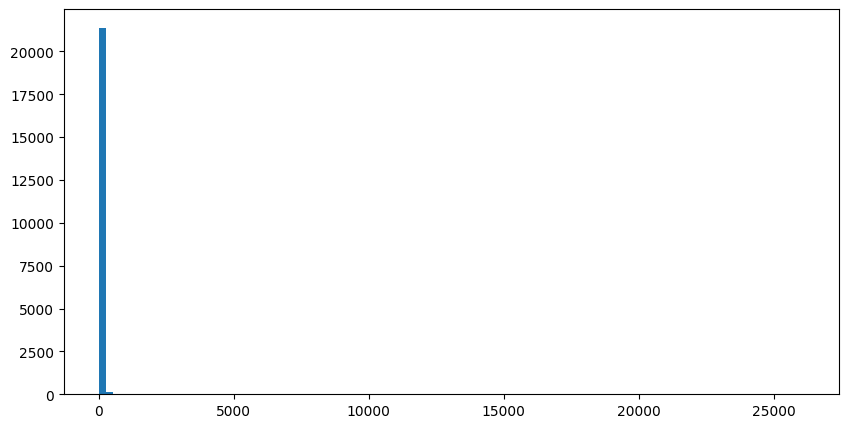

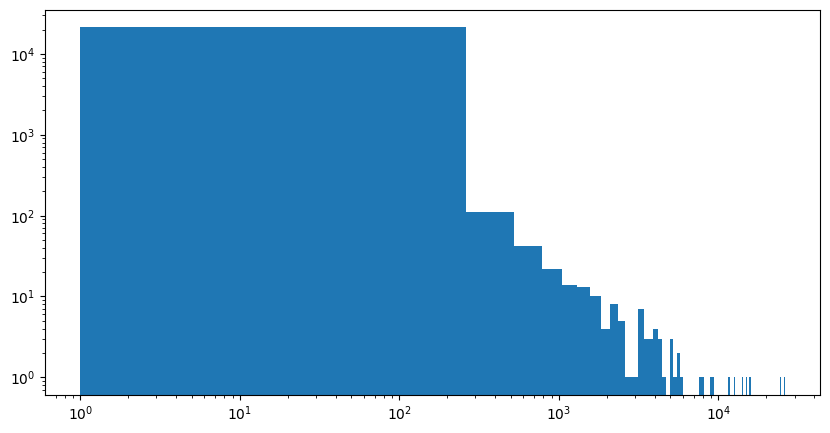

In [29]:
from collections import Counter


# Split the dialogue into words
df["Words"] = df["Dialogue"].apply(lambda x: x.split())

# Add all words to a list
words = []
for word_list in df["Words"]:
    words.extend(word_list)

# Count the number of times each word appears
word_frequency = Counter(words)

# Histogram on linear scale
_, ax = plt.subplots(figsize=(10, 5))
ax.hist(word_frequency.values(), bins=100)

# Histogram on log scale
_, ax = plt.subplots(figsize=(10, 5))
ax.hist(word_frequency.values(), bins=100)
ax.set_xscale("log")
ax.set_yscale("log")

### Part 2: Talkativity

**Q5**. For each of the recurrent characters, calculate their total number of
words uttered across all episodes. Based on this, who seems to be the most
talkative character?


In [7]:
# your code goes here

## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above
70%, say whether it's by himself or by someone else. Leonard contests this
claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set,
consisting of all the seasons except the last two, and the test set, consisting
of the last two seasons.


In [8]:
# your code goes here

**Q7**. Find the set of all words in the training set that are only uttered by
Sheldon. Is it possible for Sheldon to identify himself only based on these? Use
the test set to assess this possibility, and explain your method.


In [9]:
# your code goes here